<a href="https://colab.research.google.com/github/jana369/Breast-Cancer-Segmentation/blob/main/Breast_Cancer_Image_Segmentation_Attention_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [ ]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [ ]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

# **Data**

In [ ]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_imagess(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

def load_images(image_paths, SIZE, mask=False):
    height, width = SIZE  # Unpack SIZE tuple

    if mask:
        images = np.zeros((len(image_paths), height, width, 1))
    else:
        images = np.zeros((len(image_paths), height, width, 3))

    for i, path in enumerate(image_paths):
        img = Image.open(path)
        img = img.convert('L') if mask else img.convert('RGB')
        img = img.resize((width, height))
        img = np.array(img)

        if mask:
            img = np.expand_dims(img, axis=-1)

        images[i] = img / 255.0  # Normalize to [0, 1]

    return images


In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [ ]:
SIZE = 256

In [ ]:
# Step 1: Mount Google Drive (if not already)
from google.colab import drive
drive.mount('/content/drive')
# Step 2: Copy kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Give read-only permission
# Step 3: Install Kaggle CLI (if needed)
!pip install -q kaggle
# Step 4: Download the dataset (use the Kaggle dataset URL to get the name)
# Dataset: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset

!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
# Step 5: Unzip the dataset
!unzip breast-ultrasound-images-dataset.zip -d breast_ultrasound_data

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
Archive:  breast-ultrasound-images-dataset.zip
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_w

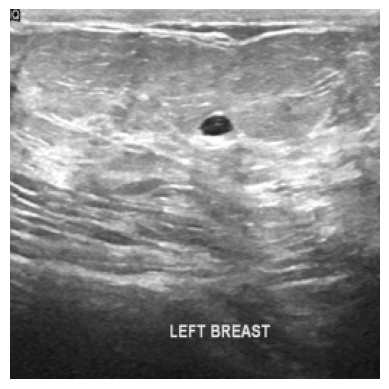

In [ ]:
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

# Example settings
root_path = '/content/breast_ultrasound_data/Dataset_BUSI_with_GT'  # Adjust to your actual dataset root
classes = ['benign', 'malignant', 'normal']
SIZE = (256, 256)

# Load all mask paths
single_mask_paths = sorted([sorted(glob(os.path.join(root_path, name, "*mask.png"))) for name in classes])
double_mask_paths = sorted([sorted(glob(os.path.join(root_path, name, "*mask_1.png"))) for name in classes])

# Build image and mask path lists
image_paths = []
mask_paths = []

for class_mask_list in single_mask_paths:
    for mask_path in class_mask_list:
        img_path = mask_path.replace('_mask', '')
        image_paths.append(img_path)
        mask_paths.append(mask_path)



# Show the first image
show_image(load_image(image_paths[0], SIZE))


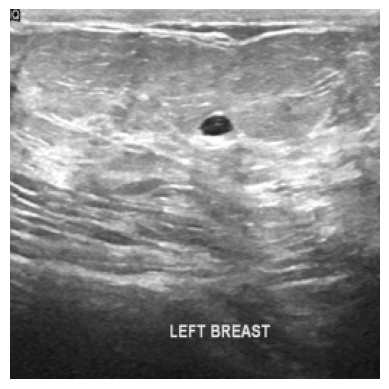

In [ ]:
show_image(load_image(image_paths[0], SIZE))

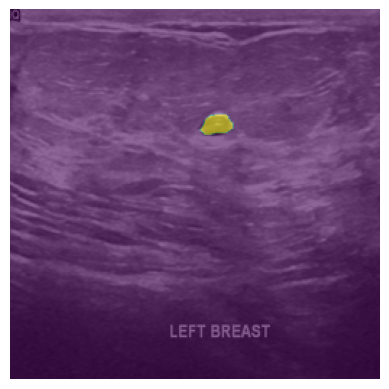

In [ ]:
# Convert mask to array before slicing
show_mask(
    load_image(image_paths[0], SIZE),
    np.array(load_image(mask_paths[0], SIZE))[:, :, 0],
    alpha=0.6
)


## **Approach**

Below here I have explained my strategy to tackel the multiple mask Images.

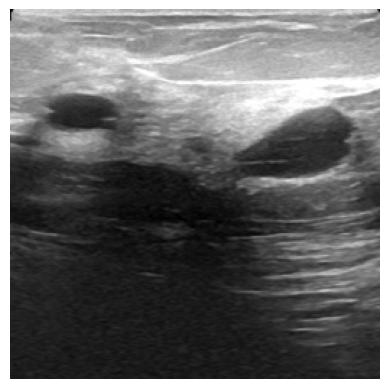

In [ ]:
show_image(load_image('/content/breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

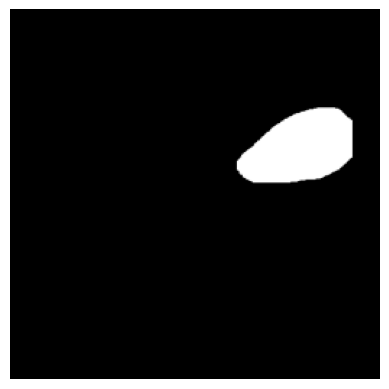

In [ ]:
show_image(load_image('/content/breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

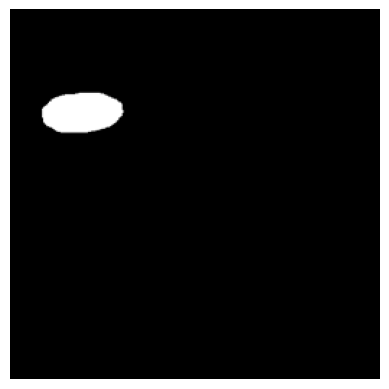

In [ ]:
show_image(load_image('/content/breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

I don't want the data this way, as both the masks belongs to the same class. A better idea can be to merge both these images

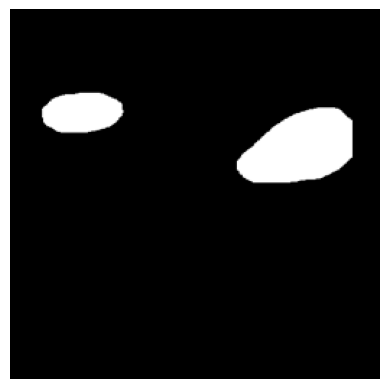

In [ ]:
img = np.zeros((1,SIZE[0],SIZE[1],3))
mask1 = load_image('/content/breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('/content/breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

We first merged them and them simple used the 1st channel because that is enough.

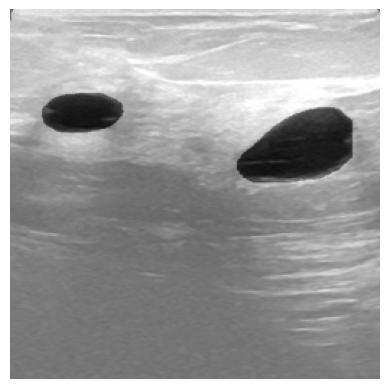

In [ ]:
show_image(load_image('/content/breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

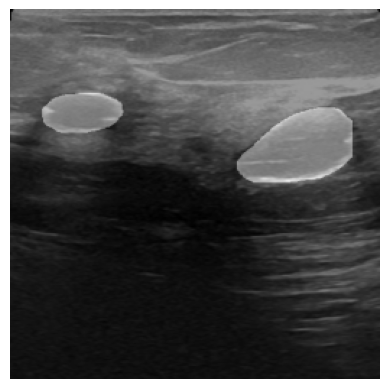

In [ ]:
show_image(load_image('/content/breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()

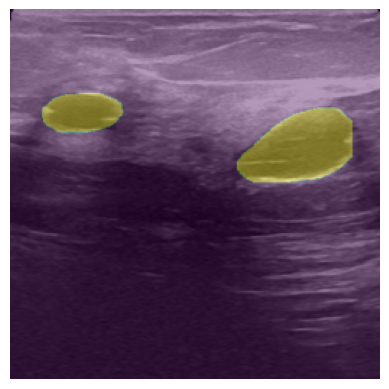

In [ ]:
show_image(load_image('/content/breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()

This is how it looks with different cmaps. But you can drop them as then are very less in number (i.e 16) and this will not affect training much.

## **Data Work**

In [ ]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

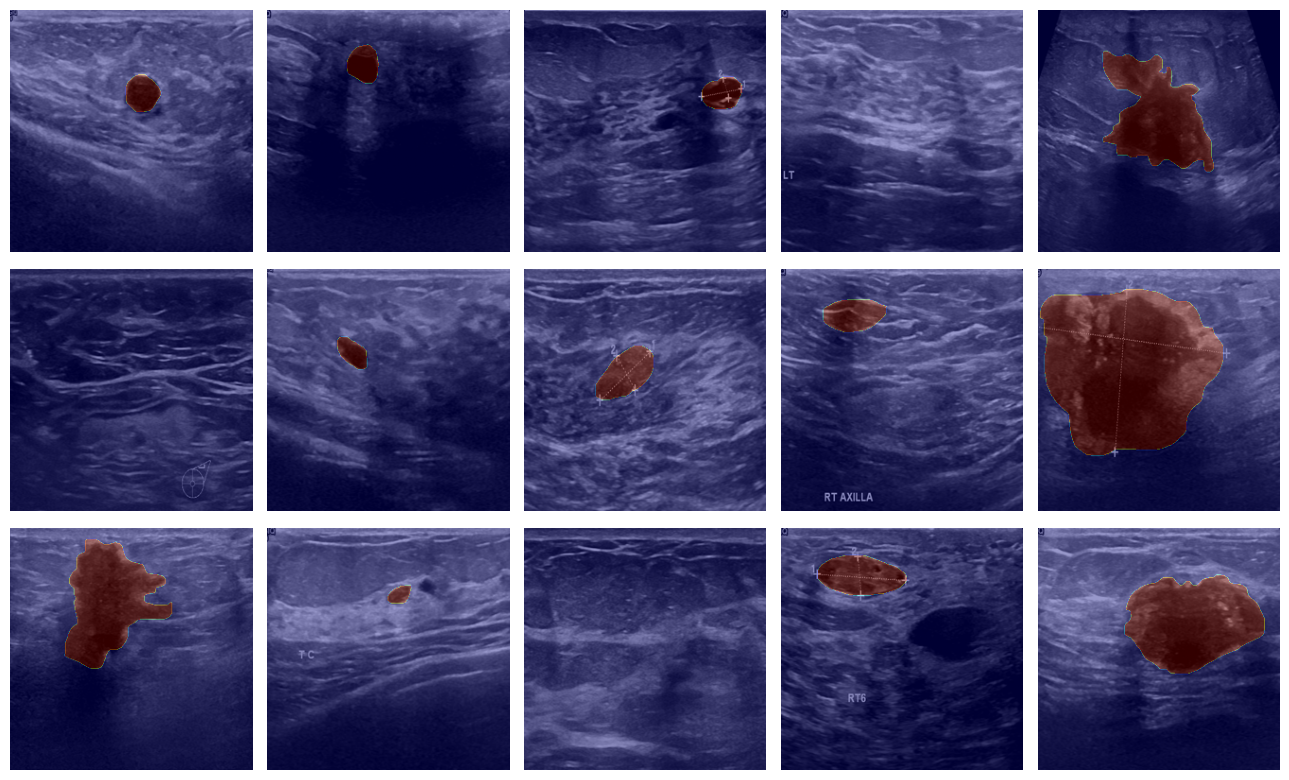

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

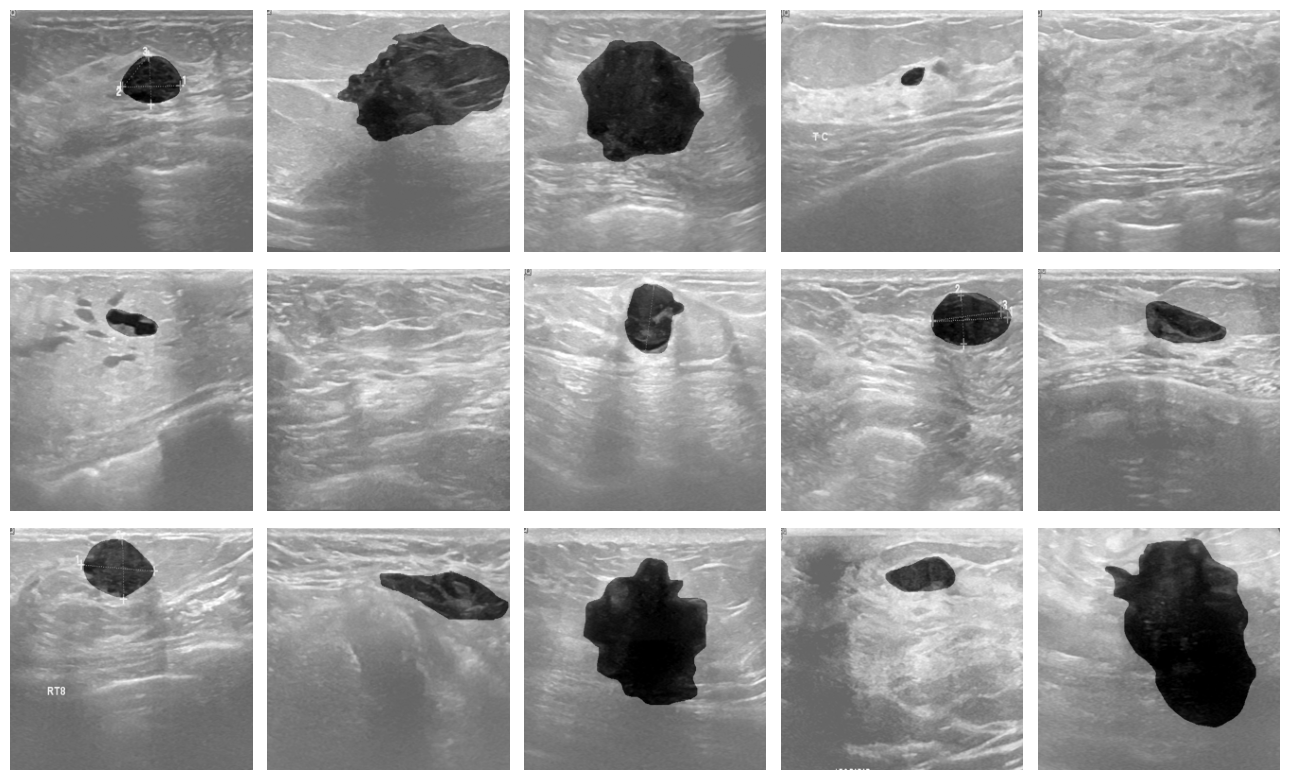

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

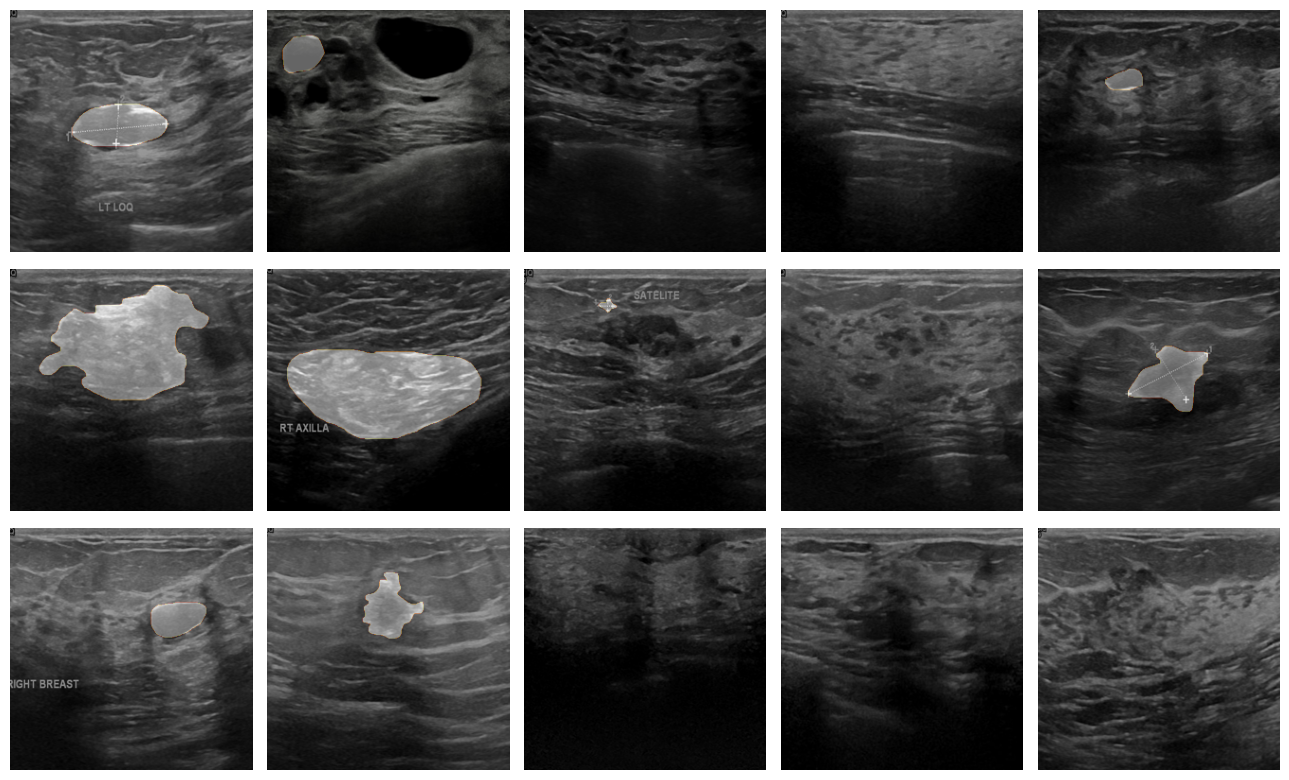

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

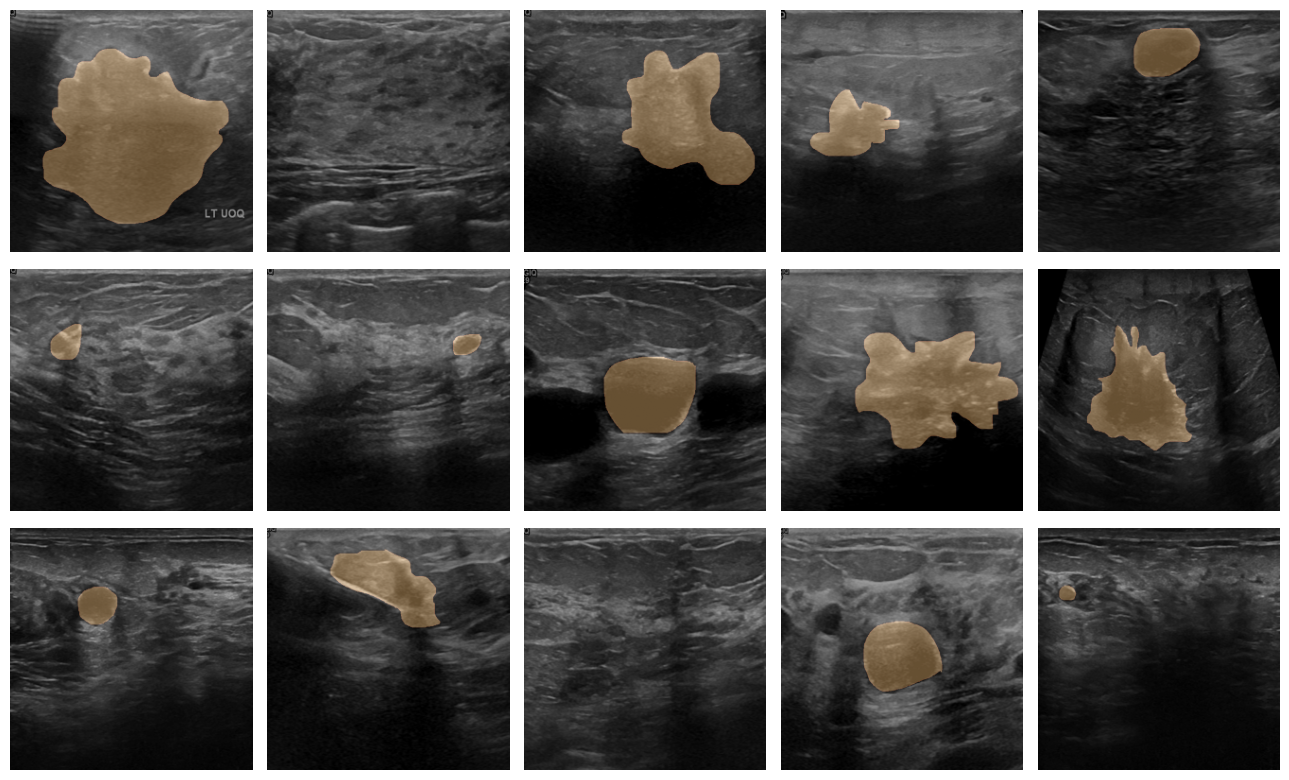

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# **Encoder**

In [ ]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [ ]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [ ]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# **Custom Callback**

In [ ]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)  # Randomly select an image from the dataset
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        class_index = 1  # or 0 based on what you want to visualize
        cam = exp.explain(
            validation_data=(image[np.newaxis, ...], mask),
            model=self.model,
            class_index=class_index  # Specify class index
        )
        # Predict mask for the selected image
        pred_mask = self.model.predict(image[np.newaxis, ...])  # Shape: (1, height, width, 1)

        # Since it's binary, we use the only channel in the prediction
        pred_mask = pred_mask[0, ..., 0]  # Get rid of batch dimension and channel dimension

        # GradCAM explanation
        cam = exp.explain(
            validation_data=(image[np.newaxis, ...], mask),
            model=self.model
        )

        # Plotting results
        plt.figure(figsize=(10, 5))

        # Original Mask
        plt.subplot(1, 3, 1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        # Predicted Mask
        plt.subplot(1, 3, 2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        # GradCAM Visualization
        plt.subplot(1, 3, 3)
        show_image(cam, title="GradCAM")

        plt.tight_layout()
        plt.show()

# **Attention UNet**

In [ ]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

# **Training**

In [ ]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=20, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
)

Epoch 1/20
78/97 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - IoU: 0.4564 - accuracy: 0.9102 - loss: 0.2375

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - IoU: 0.4562 - accuracy: 0.9099 - loss: 0.2363 - val_IoU: 0.4911 - val_accuracy: 0.9810 - val_loss: 0.2903
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - IoU: 0.4587 - accuracy: 0.9189 - loss: 0.2105 - val_IoU: 0.4911 - val_accuracy: 0.9810 - val_loss: 0.3123
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - IoU: 0.4533 - accuracy: 0.9134 - loss: 0.2148 - val_IoU: 0.4911 - val_accuracy: 0.9786 - val_loss: 0.2730
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - IoU: 0.4552 - accuracy: 0.9205 - loss: 0.2038 - val_IoU: 0.4911 - val_accuracy: 0.9819 - val_loss: 0.1568
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - IoU: 0.4552 - accuracy: 0.9236 - loss: 0.1987 - val_IoU: 0.4911 - val_accuracy: 0.9804 - val_loss: 0.0987
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - IoU: 0.4572 - accuracy: 0.9322 - loss: 0.1799 - val_IoU: 0.4911 - val_accuracy: 0.9820 - val_loss: 0.0677
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 178

**Observations :**

* After **12 epochs** model started outputting what we needed.
* The model was easily able to detect **black round spots but fails when the shape is irregular**(Not the case with current model because it is trained with hight SPE).

* It also gets confused between the dark areas, which makes sense.

---
**Suggestion :**
* Do training in chunks of **20 Epochs**, this will give you a good control **over model and the model will also perform well**.

* Here the model is trained on 17 + 17 + 17 = 51 Epochs.

* If you give the model a closer look n different images you will find that the model fails at some images, but I can garantee that 9/10 such images would be so tough that even a human will not be a able to detect as many parts of the image look the same.


# **Evaluation**

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

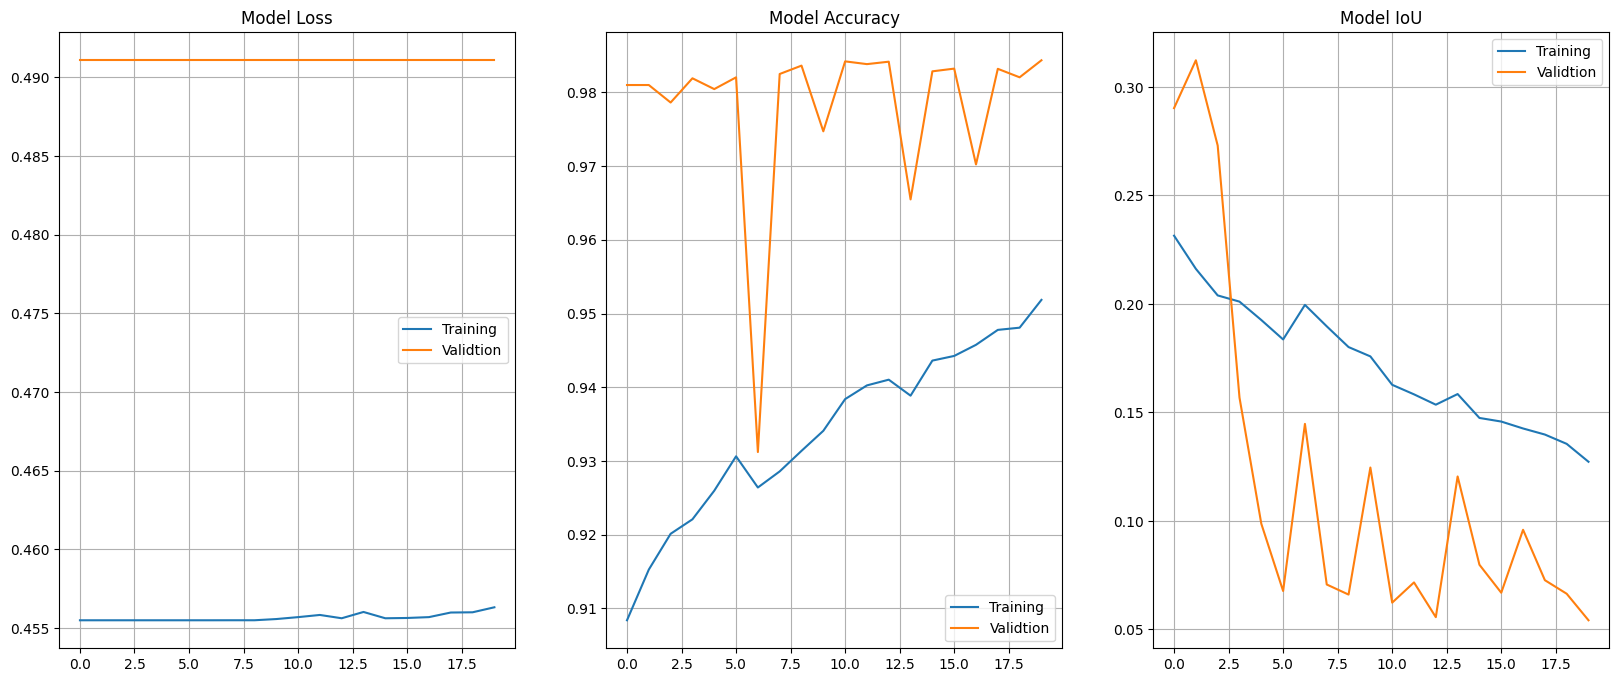

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

Suprisingly the results on **Validation Data** are **way better** than the results on **Trainind Data** on **IoU**, this may indicate that the **model can perform way better** than what it can do at the current point. The **Loss is not Perfect** it increases in the last but the model constructions are loooking perfect as this point, that's why **I believe in what I see**. This model seems promising, let's try it on some Images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


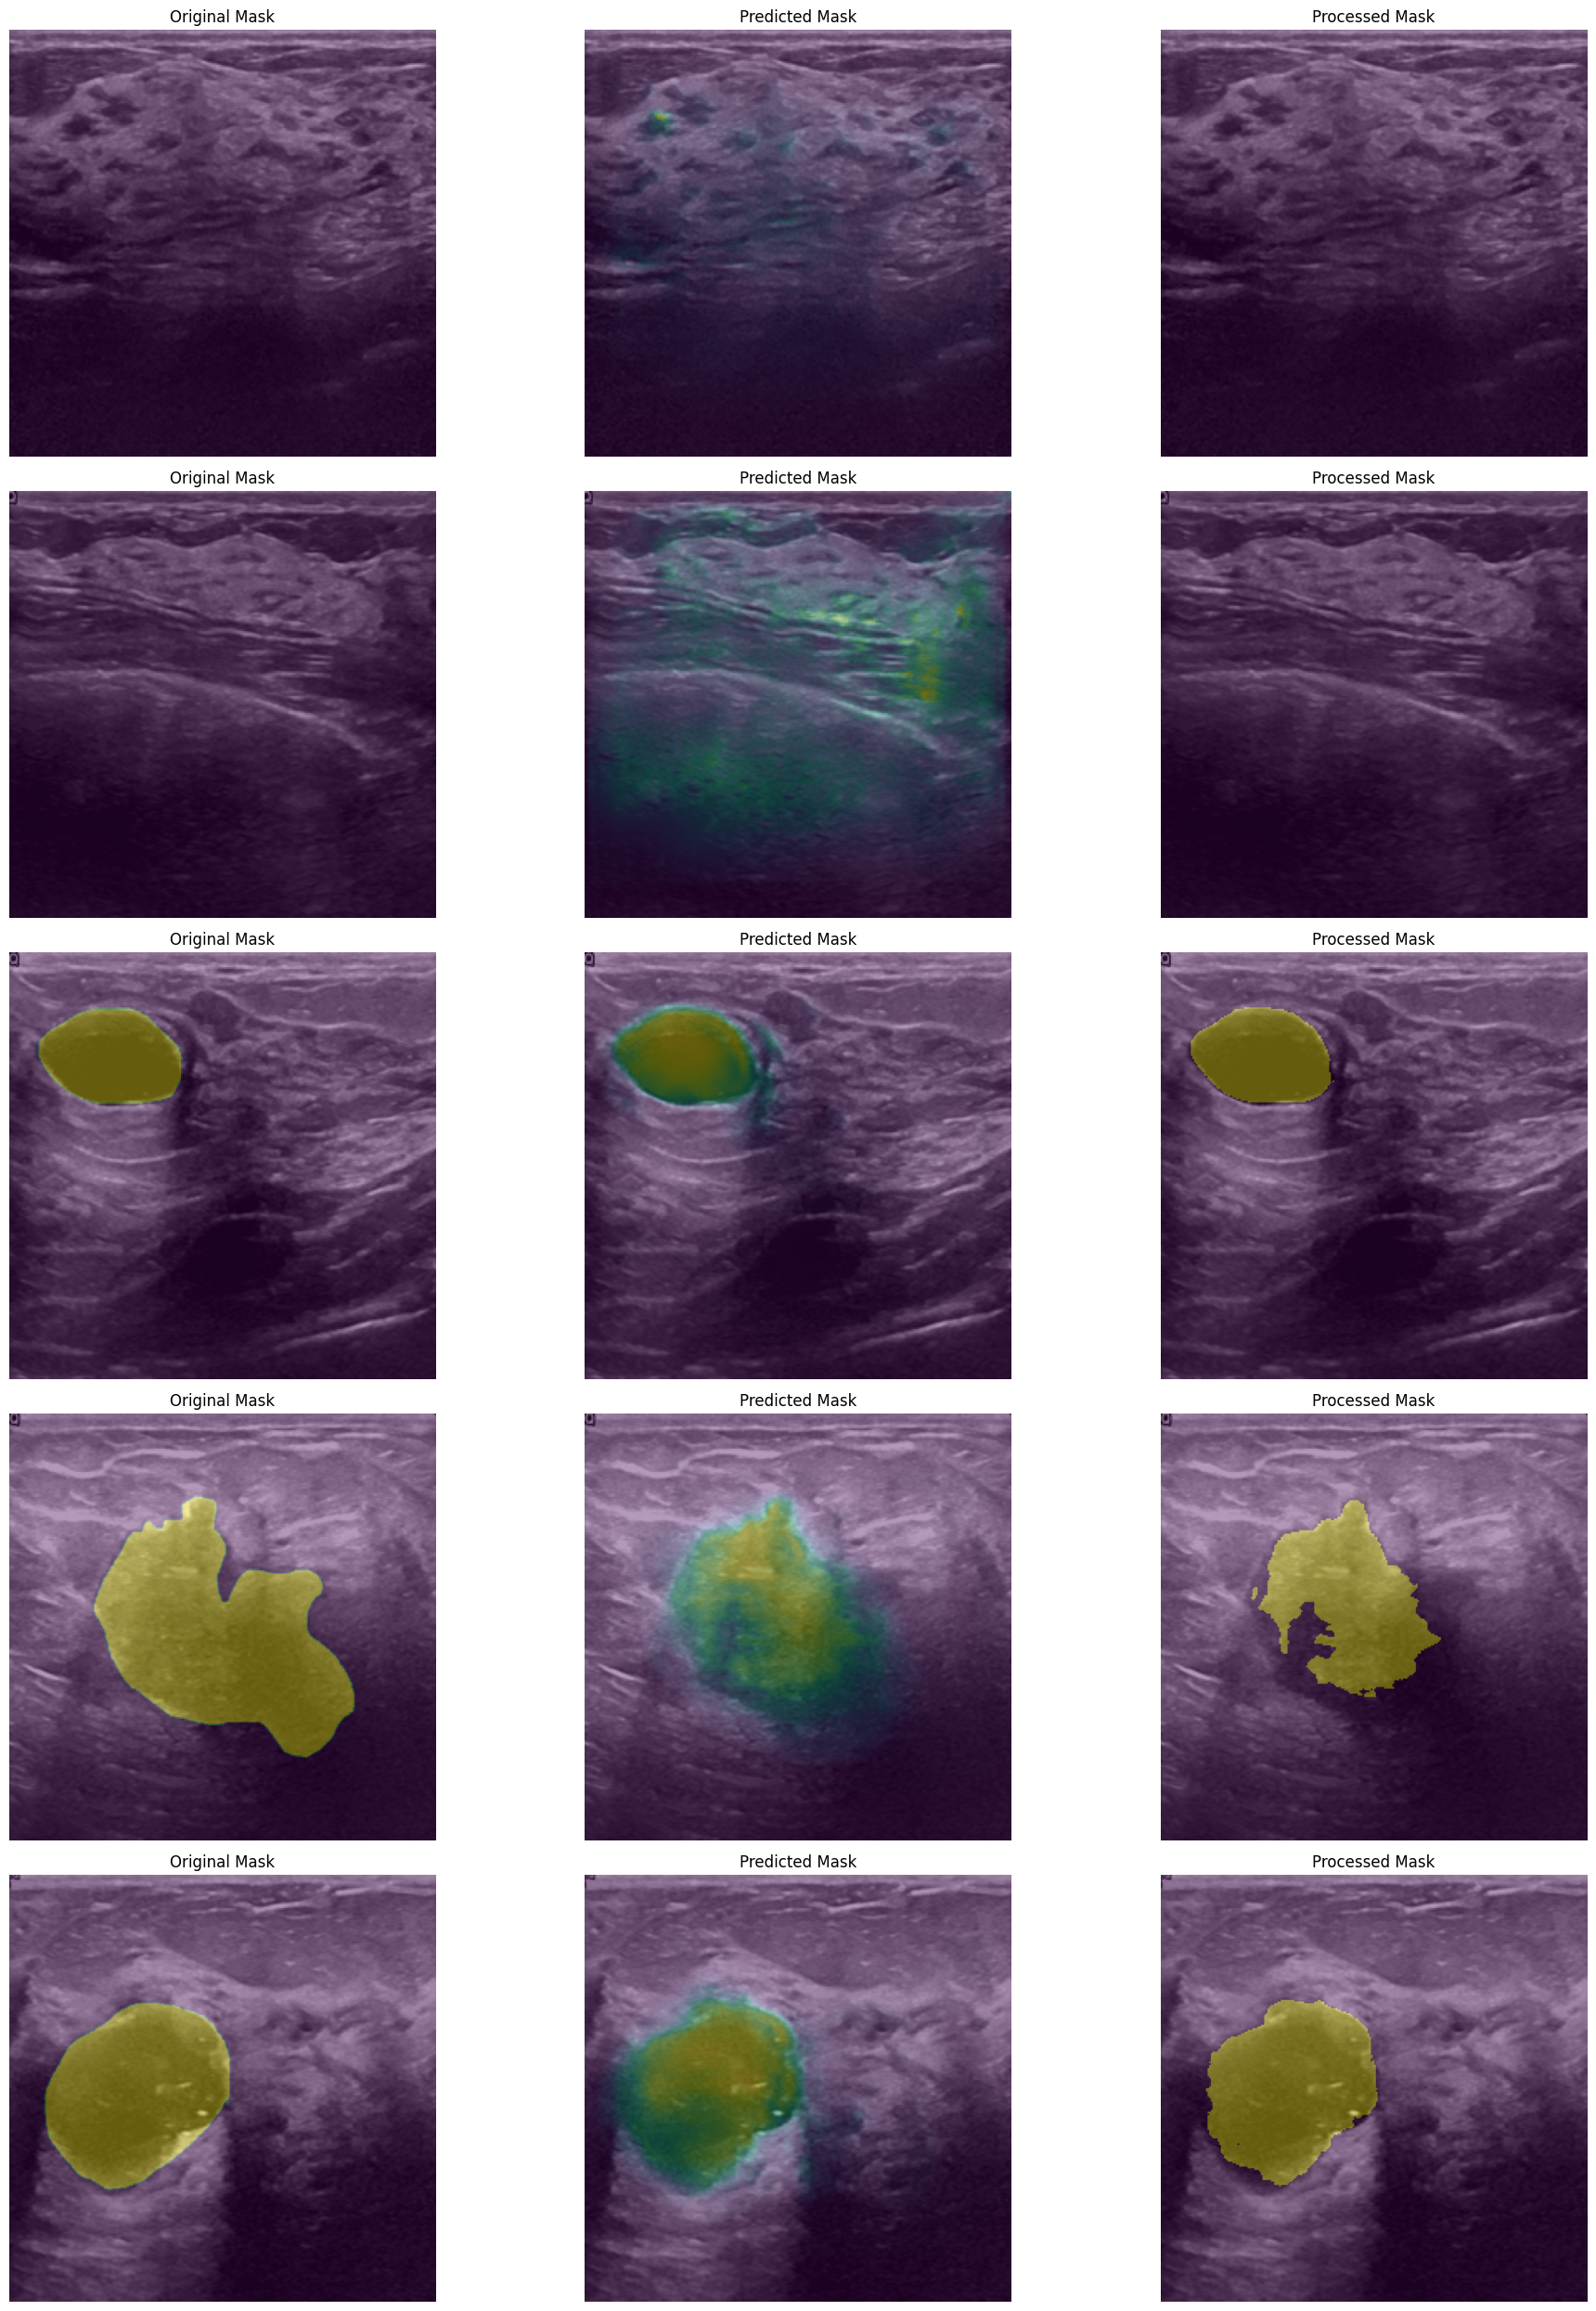

In [ ]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

The results totally convincing. If you have any suggestions please let me know 👍. **Thanks !!**